In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

print ('Hide toggle')
hide_toggle()

Hide toggle


In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import requests 
from collections import Counter
import random
import decimal
import math
import random
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

print ('Imports')
hide_toggle()

Imports


In [3]:
startDate = '2004-01-01'
finalDate = '2021-12-31'

print ("Dates")
hide_toggle()

Dates


In [5]:
##------------------------------Pegando os Dados-----------------------------------

#url = "https://apitempo.inmet.gov.br/estacao/diaria/2018-12-21/2019-03-21/A307"
url_2020 = "https://apitempo.inmet.gov.br/estacao/diaria/2020-01-01/2020-12-31/A307"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
resp_2020 = requests.get(url_2020, headers=headers)

url_2021 = "https://apitempo.inmet.gov.br/estacao/diaria/2021-01-01/2021-12-31/A307"
resp_2021 = requests.get(url_2021, headers=headers)

df = None
df_temp = None
if resp_2020.status_code != 200 or resp_2021.status_code != 200:
    print (resp_2020.raise_for_status())
    print (resp_2021.raise_for_status())

else:
    df_2020 = pd.DataFrame(resp_2020.json())
    df_2021 = pd.DataFrame(resp_2021.json())
   
    main_df_2020 = df_2020[['TEMP_MAX', 'UMID_MED', 'DT_MEDICAO']]
    main_df_2021 = df_2021[['TEMP_MAX', 'UMID_MED', 'DT_MEDICAO']]

frames = [main_df_2020, main_df_2021]
main_df = pd.concat(frames)
main_df = main_df.reset_index()
main_df["id"] = main_df.index + 1

print ("Request datas")
hide_toggle()

Request datas


In [11]:
temp_max = main_df['TEMP_MAX']

In [7]:
df_training_temp = None
df_training_temp_anomalie_edit = None
desvioPadraoTempTraining = 0
desvioPadraoUmidTraining = 0

desvioPadraoTempTest = 0
desvioPadraoUmidTest = 0

desvioPadrao = 0

import statistics
def replaceValues(listValues):
    for i in range(len(listValues)):
        if listValues[i] == None:
            listAux = pd.to_numeric(listValues[i-7:i], errors='coerce')
            listValues[i] = str(float("{:.2f}".format(statistics.mean(listAux))))

def valorFinalTemperatura(df_training_temp_anomalie_edit, treino, equacaoExponencial):
    valorFinalTemp = equacaoExponencial * extrairErro(df_training_temp_anomalie_edit, 'TEMP_MAX')
    return valorFinalTemp

def valorFinalUmidade(df_training_temp_anomalie_edit, treino, equacaoExponencial):
    valorFinalUmid = equacaoExponencial * extrairErro(df_training_temp_anomalie_edit, 'UMID_MED')
    return valorFinalUmid

def qtdRowsTemp():
    count_row_temp = df_temp.shape[0]
    return count_row_temp

def extrairErro(dataframe, coluna):
    train_size = int(dataframe.shape[0] * 1)
    train_Real, train_Pred = dataframe.to_numpy()[:,0], dataframe.to_numpy()[:,1]
    train_resid = [train_Real[i]-train_Pred[i] for i in range(len(dataframe))]
    desvioErro = np.std(train_resid)
    return desvioErro

def TransformarEmEstacionaria(df_training_temp):
    converterColunasToFloat(df_training_temp, "TEMP_MAX")
    converterColunasToFloat(df_training_temp, "UMID_MED")

    df_training_temp['UMID_MED'] = df_training_temp['UMID_MED'].diff()
    df_training_temp['TEMP_MAX'] = df_training_temp['TEMP_MAX'].diff()
    df_training_temp.dropna()
    return df_training_temp

def equacaoExponencial():
    numberX = decimal.Decimal(random.randrange(-50, 50))/100
    eq = math.exp((3 * abs(numberX))) + 3
    return float(eq)

def converterColunasToFloat(dataframe, coluna):
    dataframe[coluna] = dataframe[coluna].astype(float)
    dataframe[coluna].apply(lambda x: float(x))
    return dataframe


def autoReg(dataframe_anomalies_edit):
    ar_model = AutoReg(np.array(dataframe_anomalies_edit), trend='n', lags=1).fit()
    pred = ar_model.predict(start=0,end= dataframe_anomalies_edit.shape[0], dynamic=False)
    return pred

print ("Functions")
hide_toggle()

Functions


In [8]:

#------------------------------Tratando os Dados-----------------------------------

dfAnomaliasFinal = pd.DataFrame()
df_train = pd.DataFrame()

def dataTraining(percentOutliers):

    df_training_temp = main_df

    df_training_temp = TransformarEmEstacionaria(df_training_temp) #Série Estacionária
    df_train = TransformarEmEstacionaria(df_training_temp)
    
    count_training_temp = int((df_training_temp.shape[0] * percentOutliers) / 100)    
    df_training_temp_anomalie_edit = df_training_temp.sample(n=count_training_temp)
    
    df_test_temp = pd.concat([df_temp, df_training_temp]).drop_duplicates(keep=False)

    df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_training_temp_anomalie_edit.dropna(inplace=True)

    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "TEMP_MAX")
    #df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "UMID_MED")

    equacaoExpo = equacaoExponencial()
    
    temperaturas = autoReg(df_training_temp_anomalie_edit['TEMP_MAX']) #AutoRegressão
    umidades = autoReg(df_training_temp_anomalie_edit['UMID_MED']) #AutoRegressão
    
    df_ids = np.array(df_training_temp_anomalie_edit['id'])
    
    df_temp_real_pred = pd.DataFrame()
    colTemp = ['temp_real','temp_pred']
    df_temp_real_pred = pd.DataFrame(columns=colTemp)
    df_temp_real_pred['temp_real'] = df_training_temp_anomalie_edit['TEMP_MAX']
    df_temp_real_pred['temp_pred'] = temperaturas.tolist()

    df_umid_real_pred = pd.DataFrame()
    col_umid = ['umid_real','umid_pred']
    df_umid_real_pred = pd.DataFrame(columns=col_umid)
    df_umid_real_pred['umid_real'] = df_training_temp_anomalie_edit['UMID_MED']
    df_umid_real_pred['umid_pred'] = umidades.tolist()
    
    valorFinalTemp = valorFinalTemperatura(df_temp_real_pred, True, equacaoExpo)
    valorFinalUmid = valorFinalUmidade(df_umid_real_pred, True, equacaoExpo)
    
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "UMID_MED")
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "TEMP_MAX")

    dfAnomalias = pd.DataFrame()
    col = ['TEMP_MAX','UMID_MED', 'id']

    dfAnomalias = pd.DataFrame(columns=col)

    df_training_temp_anomalie_edit.sort_index(inplace=True)

    for index, row in df_training_temp_anomalie_edit.iterrows():
        temp = row['TEMP_MAX'] + (np.sign(row['TEMP_MAX']) * valorFinalTemp)
        umid = row['UMID_MED'] + (np.sign(row['UMID_MED']) * valorFinalUmid)
        x = np.array([[temp, umid, row['id']]], np.float)
        df1=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED', 'id'])        
        df1.set_index('id',inplace=True)

        dfAnomalias = pd.concat([df1, dfAnomalias])
        
    dfAnomalias = dfAnomalias.drop(columns='id')
        
    dfAnomalias.sort_index(inplace=True)    

    print ('Anomalias: ')
    print (dfAnomalias)
    dfFinal = dfAnomalias

    for index, row in df_training_temp.iterrows():
        x = np.array([[row['TEMP_MAX'], row['UMID_MED'], row['id']]], np.float)
        df1=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED', 'id'])
        df1.set_index('id',inplace=True)
        
        dfFinal = pd.concat([df1, dfFinal])

    dfFinal.sort_index(inplace=True)    
    df_training_temp = dfFinal
    df_training_temp.dropna(inplace=True)

    dfAnomalias.sort_index(inplace=True)
 
    #Treino
    df_training_temp = converterColunasToFloat(df_training_temp, "TEMP_MAX")
    df_training_temp = converterColunasToFloat(df_training_temp, "UMID_MED")
    df_training_temp.sort_index(inplace=True)

    return df_training_temp, dfAnomalias, df_train

print ("Tratamento dos Dados")
hide_toggle()

Tratamento dos Dados


In [9]:
replaceValues(temp_max)

In [16]:
main_df['DT_MEDICAO'] = pd.to_datetime(main_df['DT_MEDICAO'])
main_df['TEMP_MAX'] = main_df['TEMP_MAX'].astype(float)


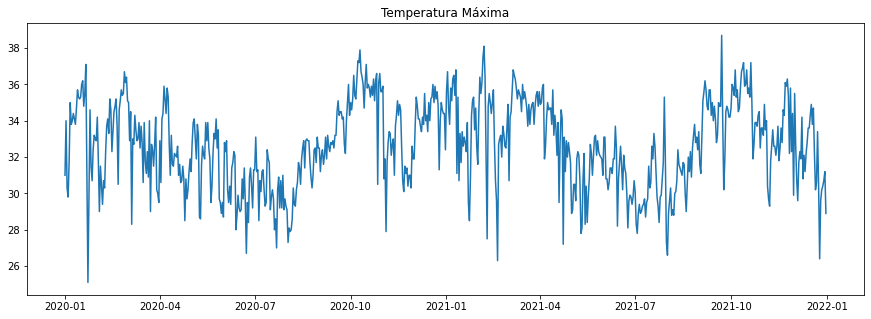

In [17]:
plt.figure(figsize=(15,5))
plt.plot(main_df['DT_MEDICAO'], main_df['TEMP_MAX'], color='#1f77b4')
plt.title('Temperatura Máxima')
plt.show()

In [18]:
#import random

taxaContaminacao = 5
dfs = dataTraining(taxaContaminacao)
df_training_temp = dfs[0]
dfAnomalias = dfs[1]
dfTrain = dfs[2]
print (dfAnomalias.shape)
#df_training_temp = df_training_temp[df_training_temp.index.notnull()]

/home/anderson/Documentos/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/anderson/Documentos/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Anomalias: 
        TEMP_MAX   UMID_MED
12.0   15.781412 -36.903287
14.0  -15.981412  40.603287
24.0   25.281412 -50.703287
67.0  -19.581412  36.003287
81.0  -17.181412  41.803287
91.0  -14.881412  35.703287
123.0  16.881412 -37.303287
125.0 -15.481412   0.000000
147.0 -17.281412  45.403287
150.0  18.181412 -57.203287
185.0 -18.281412  46.803287
235.0  14.681412 -37.203287
255.0  14.881412  36.003287
263.0 -15.281412  41.903287
273.0   0.000000 -36.503287
311.0 -17.281412 -37.503287
330.0 -15.881412 -36.803287
338.0 -14.981412  38.903287
359.0 -15.781412  43.803287
385.0 -15.381412 -37.603287
396.0 -17.881412  43.403287
426.0  14.781412 -48.403287
435.0 -14.681412 -36.003287
478.0 -16.881412  42.303287
489.0  15.781412   0.000000
498.0  16.981412  35.903287
499.0 -15.881412  43.403287
538.0 -17.181412  41.203287
541.0 -15.381412 -37.703287
548.0 -16.081412  45.303287
577.0 -21.681412  45.503287
596.0 -16.081412  43.203287
604.0 -15.481412  40.503287
607.0  15.881412 -39.703287
672.0  1

In [31]:

 = main_df.drop(main_df.index[0])

In [32]:
main_df

,index,TEMP_MAX,UMID_MED,DT_MEDICAO,id
2,2,-6.7,19.7,2020-01-03,3
3,3,3.2,-15.4,2020-01-04,4
4,4,2.5,4.7,2020-01-05,5
5,5,1.2,-10.7,2020-01-06,6
6,6,-4.4,20.7,2020-01-07,7
...,...,...,...,...,...
726,360,-2.6,1.5,2021-12-27,727
727,361,-0.4,-0.6,2021-12-28,728
728,362,0.1,0.3,2021-12-29,729
729,363,0.2,7.5,2021-12-30,730


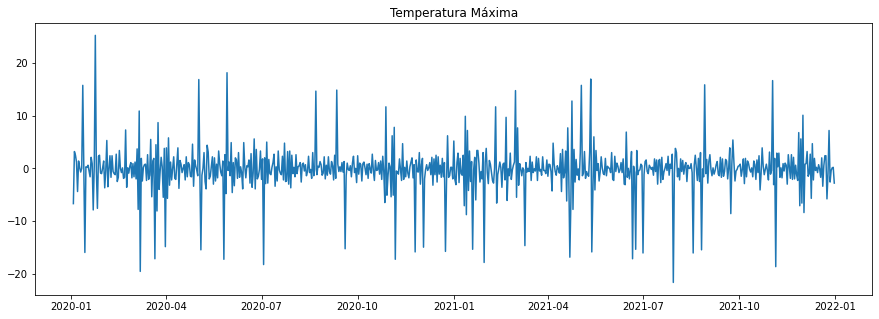

In [33]:
plt.figure(figsize=(15,5))
plt.plot(main_df['DT_MEDICAO'], df_training_temp['TEMP_MAX'], color='#1f77b4')
plt.title('Temperatura Máxima')
plt.show()

In [11]:
df_train_final = dfTrain.drop(['DT_MEDICAO', 'id'], axis=1)

In [46]:
len(df_train_final)

731

In [12]:
#Credits
#https://github.com/chriswernst/dbscan-python/blob/master/dbscan.py

#------------------------------Implementando o DBSCAN-----------------------------------
def dbscan(df_used, eps, min_samples):
    X = StandardScaler().fit_transform(df_used)
    db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='auto').fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    labels = db.labels_

    outliers = df_used[db.labels_ == -1]

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Preto usado para ruído
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    outliers = outliers[outliers.index.notnull()]
    
    #print('Outliers encontrados: ')
    #print (outliers.shape)
    #print (outliers)

    plt.title('Número estimado de clusters: %d' % n_clusters_)
    plt.xlabel("TEMP_MAX")
    plt.ylabel("UMID_MED")
    plt.show()
    return outliers

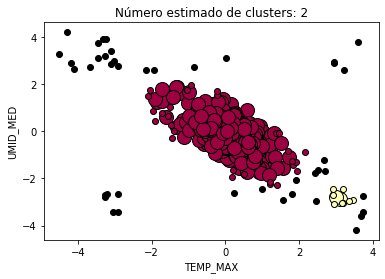

        TEMP_MAX   UMID_MED
19.0  -13.377077 -34.927282
22.0   -7.900000  32.600000
24.0   10.700000 -15.200000
31.0   11.877077  37.327282
44.0   14.477077  47.527282
66.0   10.900000 -20.800000
67.0  -16.777077  33.427282
73.0  -14.077077  47.027282
95.0  -14.977077  34.627282
128.0  14.777077 -45.027282
175.0 -12.677077  43.027282
199.0  15.077077 -42.727282
212.0  14.277077 -52.527282
287.0 -11.877077 -42.927282
288.0 -12.677077  36.227282
308.0   6.200000 -36.500000
317.0 -14.077077  39.427282
324.0 -13.577077  49.627282
375.0 -13.077077 -33.127282
378.0   9.900000 -37.200000
379.0  -8.800000  32.600000
380.0   7.200000 -33.100000
413.0  -3.600000  34.600000
414.0   0.800000 -32.800000
417.0   9.700000 -22.100000
420.0 -13.177077  49.527282
425.0  12.977077  33.027282
428.0   7.700000 -25.900000
435.0 -11.877077 -33.427282
444.0 -11.877077  34.727282
464.0 -12.377077  37.427282
474.0  15.077077 -34.627282
496.0 -13.277077  40.127282
500.0 -17.077077  36.327282
568.0 -12.477077 -42

In [37]:
eps = 0.5
min_samples = 10
#print(df_training_temp.head(n=50).to_string(index=True))
outliers = dbscan(df_training_temp, eps, min_samples)
#dfOutliersErrados = pd.concat([outliers, dfAnomalias]).drop_duplicates(keep=False)
#print (outliers)
print(outliers.head(n=80).to_string(index=True))


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc

dfTemp = pd.DataFrame()
colTemp = ['TEMP_MAX', 'UMID_MED']
dfTemp = pd.DataFrame(columns=colTemp)

dfTemp[['TEMP_MAX', 'UMID_MED']] = df_training_temp[['TEMP_MAX', 'UMID_MED']]

'''counter = int((dfTemp.shape[0] * 30) / 100)
df_test_temp = dfTemp.sample(n=counter, random_state=1)
df_train_temp = pd.concat([dfTemp, df_test_temp]).drop_duplicates(keep=False)'''

model=IsolationForest(n_estimators=100, contamination='auto').fit(dfTemp)

#dfTemp['scores']=model.decision_function(dfTemp)
dfTemp['anomaly']=model.predict(dfTemp)

anomalyTemp=dfTemp.loc[dfTemp['anomaly']==-1]
anomaly_index=list(anomalyTemp.index)

print (dfTemp.shape[0])
print(anomalyTemp.head(n=200).to_string(index=True))
print(len(anomalyTemp))

729
        TEMP_MAX   UMID_MED  anomaly
3.0    -6.700000  19.700000       -1
7.0    -4.400000  20.700000       -1
22.0   -7.900000  32.600000       -1
23.0    0.600000 -24.500000       -1
24.0   10.700000 -15.200000       -1
26.0   -7.600000  15.900000       -1
34.0  -11.321958  49.278148       -1
35.0    5.300000 -16.700000       -1
44.0    2.700000  14.600000       -1
53.0    7.300000 -17.600000       -1
65.0   -7.800000   5.400000       -1
66.0   10.900000 -20.800000       -1
73.0  -13.221958  52.978148       -1
77.0    5.500000  -0.900000       -1
82.0    4.500000 -10.000000       -1
83.0   -8.100000  11.100000       -1
84.0    8.700000 -10.700000       -1
89.0   -5.500000  19.800000       -1
93.0   -5.700000   0.200000       -1
94.0    5.800000  -1.000000       -1
103.0   3.900000 -19.300000       -1
106.0  11.721958  49.378148       -1
115.0 -12.421958  45.778148       -1
143.0  11.821958 -49.178148       -1
150.0   3.600000 -21.700000       -1
154.0   4.900000  -1.800000       

In [72]:
anomalyTemp['ind'] = anomalyTemp.index
anomalies_pred_index = anomalyTemp['ind'].values

<ipython-input-72-8dbb64f5cf82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalyTemp['ind'] = anomalyTemp.index


In [73]:
df_anomalias = dfAnomalias
df_anomalias['ind'] = dfAnomalias.index
anomalies_index = df_anomalias['ind'].values

In [74]:
VP = 0
FN = 0
for i in anomalies_pred_index:
    if i in anomalies_index:
        VP += 1

for i in anomalies_index:
    if i not in anomalies_pred_index:
        FN += 1
        
FP = len(anomalyTemp) - len(dfAnomalias)
qtd_sem_anomalia = len(df_training_temp) - len(dfAnomalias)
VN = qtd_sem_anomalia - FP

print ('VP: ' + str(VP))
print ('VN: ' + str(VN) + " de " + str(qtd_sem_anomalia))
print ('FP: ' + str(FP))
print ('FN: ' + str(FN))


VP: 36
VN: 656 de 693
FP: 37
FN: 0


In [54]:
len(df_training_temp) 

729

'plt.legend(\n    [p1, p2],\n    ["training observations", "detected outliers"],\n    loc="lower right",\n)'

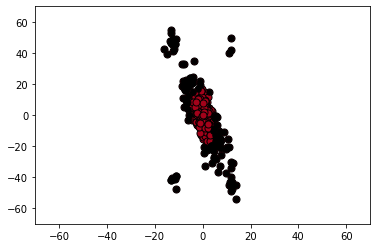

In [19]:
p1 = plt.scatter(df_training_temp.TEMP_MAX, df_training_temp.UMID_MED, c="#a3021a", edgecolor="black", s=50)
p2 = plt.scatter(anomalyTemp.TEMP_MAX, anomalyTemp.UMID_MED,
    c="black",
    s=30
)


plt.xlim((-70, 70))
plt.ylim((-70, 70))
'''plt.legend(
    [p1, p2],
    ["training observations", "detected outliers"],
    loc="lower right",
)'''

In [78]:
df_without_anomalie = pd.concat([df_training_temp, dfAnomalias]).drop_duplicates(keep=False)